<a href="https://colab.research.google.com/github/TurkuNLP/register-DeepL/blob/main/register_simple_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This is not true multilabel because we just use the many unique combinations as the possibility for a new single label**

In [1]:
!wget -nc https://github.com/TurkuNLP/register-DeepL/blob/main/AfterDeepL/es_FINAL.tsv.gz # the repo is private so this does not work lol

File ‘es_FINAL.tsv.gz’ already there; not retrieving.



Before running this notebook put the file in the directory.

In [2]:
!pip3 install -q transformers datasets

In [3]:
import transformers
import datasets
import gzip 
import random
import re
import json

from pprint import PrettyPrinter
import logging
pprint = PrettyPrinter(compact=True).pprint
logging.disable(logging.INFO)

In [4]:
file_name = "es_FINAL.tsv.gz"
data=[]
with gzip.open(file_name, 'rb') as f:
    for line in f:
        line = line.decode()
        line=line.rstrip("\n")
        if not line or line.startswith("#"): #skip empty and comments (incl. header)
            continue
        cols=line.split("\t")
        if len(cols)!=2: #skip weird lines that don't have the right number of columns
            continue
        data.append(cols)

pprint(data[0])

['NA OP',
 "El martes por la noche, Sarah Palin se pasó por el programa de Bill O'Reilly "
 'para hablar de algunos comentarios recientes de Laura Ingraham, así como del '
 'enfoque que debería adoptar la candidatura de Romney/Ryan en la recta final '
 'de la campaña. Insistiendo en el argumento de que Mitt Romney debe ser más '
 'agresivo, Palin definió las elecciones como una elección entre "cosas gratis '
 'o libertad". Preguntada por el comentario de Ingraham de que si los '
 'republicanos no pueden ganar estas elecciones, deberían cerrar el partido, '
 'Palin también estuvo de acuerdo en que estas elecciones deberían favorecer a '
 'Romney. Rush Limbaugh dijo igualmente que la reelección del presidente '
 'señalaría el fin del GOP. La cuestión, dijo, es que el mensaje llegue a los '
 'votantes. "Si no puedes hacer llegar tu mensaje a través de ese filtro de '
 'los medios de comunicación, entonces estamos en un mundo de dolor", dijo. Lo '
 'que los republicanos no están haciendo, 

In [5]:
random.seed(1234) # remember to shuffle since the data is now in en,fi,swe,fre order
random.shuffle(data) 

In [6]:
# get a list of all the unique labels in the data using set which does not allow duplicates

labels = [one[0] for one in data]

labelset = set(labels) #split_labels
unique_labels=list(labelset)

#texts= [one[1] for one in data]
print(len(unique_labels)) # only 43 when splitting the labels but 358 when not!!!
print(unique_labels[:10])

358
['NA IN CB DT', 'ID OP AV', 'NA LY PB SO', 'IP ID DS', 'OA NA OP', 'IN IP IB', 'IN OP', 'IP OP DS AV', 'IN OP DT RS', 'IN IP JD']


In [7]:
with open("translated-register-data.jsonl", "wt") as f:
    for cols in data:
        item = {
            "text": cols[1],
            "label": unique_labels.index(cols[0]), 
        }
        print(json.dumps(item,ensure_ascii=False,sort_keys=True),file=f)

In [8]:
file = "translated-register-data.jsonl"
dataset = datasets.load_dataset(
    'json',                             
    data_files={"everything":file}, # I need the test set from Veronika? ask Filip and Veronika
    split={
        "train":"everything[:80%]",  
        "validation":"everything[80%:90%]",   
        "test":"everything[90%:]"    
    },
    features=datasets.Features({
        "label":datasets.ClassLabel(names=unique_labels),
        "text":datasets.Value("string")
    })
)


Using custom data configuration default-d4b2cc45d57f9fad


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-d4b2cc45d57f9fad/0.0.0/ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [9]:
model_name = "xlm-roberta-base" # we use the xlmr for tokenizing (large?, I used base previously)
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

def tokenize(example):
    return tokenizer(
        example["text"],
        max_length=512,
        truncation=True, # do something else other than truncating? the texts now have max 1024 tokens
    )

dataset = dataset.map(tokenize)

  0%|          | 0/7414 [00:00<?, ?ex/s]

  0%|          | 0/926 [00:00<?, ?ex/s]

  0%|          | 0/927 [00:00<?, ?ex/s]

In [10]:
model = transformers.XLMRobertaForSequenceClassification.from_pretrained(model_name, num_labels=len(unique_labels))

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

In [11]:
trainer_args = transformers.TrainingArguments(
    "checkpoints",
    evaluation_strategy="steps",
    logging_strategy="steps",
    load_best_model_at_end=True,
    eval_steps=100,
    logging_steps=100,
    learning_rate=0.00001,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=32,
    max_steps=1500
)

In [12]:
accuracy = datasets.load_metric("accuracy")

def compute_accuracy(outputs_and_labels):
    outputs, labels = outputs_and_labels
    predictions = outputs.argmax(axis=-1) #pick the index of the "winning" label
    return accuracy.compute(predictions=predictions, references=labels)


data_collator = transformers.DataCollatorWithPadding(tokenizer)


# for the actual multilabel thing we need to use another metric

In [13]:
from collections import defaultdict

class LogSavingCallback(transformers.TrainerCallback):
    def on_train_begin(self, *args, **kwargs):
        self.logs = defaultdict(list)
        self.training = True

    def on_train_end(self, *args, **kwargs):
        self.training = False

    def on_log(self, args, state, control, logs, model=None, **kwargs):
        if self.training:
            for k, v in logs.items():
                if k != "epoch" or v not in self.logs[k]:
                    self.logs[k].append(v)

training_logs = LogSavingCallback()

early_stopping = transformers.EarlyStoppingCallback(
    early_stopping_patience=5
)

In [14]:
trainer = transformers.Trainer(
    model=model,
    args=trainer_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    compute_metrics=compute_accuracy,
    data_collator=data_collator,
    tokenizer = tokenizer,
    callbacks=[early_stopping, training_logs]
)

trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Step,Training Loss,Validation Loss,Accuracy
100,5.626700,5.160537,0.068035
200,5.044700,4.762479,0.068035
300,4.742700,4.548610,0.069114
400,4.529200,4.406613,0.069114
500,4.401400,4.280372,0.104752
600,4.307900,4.224647,0.109071
700,4.236000,4.106801,0.120950
800,4.115100,4.058669,0.133909
900,4.044700,4.039058,0.128510
1000,4.035300,3.983800,0.138229


TrainOutput(global_step=1500, training_loss=4.310118204752604, metrics={'train_runtime': 3322.6797, 'train_samples_per_second': 3.612, 'train_steps_per_second': 0.451, 'total_flos': 3165865733571264.0, 'train_loss': 4.310118204752604, 'epoch': 1.62})

In [19]:
eval_results = trainer.evaluate(dataset["test"])

print('Accuracy:', eval_results['eval_accuracy'])

Accuracy: 0.19201725997842503


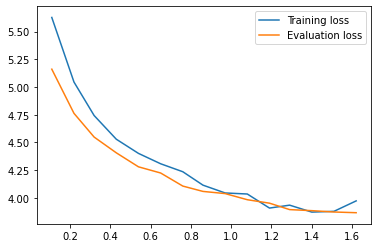

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot(logs, keys, labels):
    values = sum([logs[k] for k in keys], [])
    plt.ylim(max(min(values)-0.1, 0.0), min(max(values)+0.1, 6.0))
    for key, label in zip(keys, labels):    
        plt.plot(logs["epoch"], logs[key], label=label)
    plt.legend()
    plt.show()

plot(training_logs.logs, ["loss", "eval_loss"], ["Training loss", "Evaluation loss"])

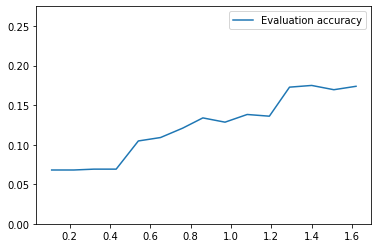

In [21]:
plot(training_logs.logs, ["eval_accuracy"], ["Evaluation accuracy"])

I think there are several reasons this does not work at all really:



1.   The original en,fi,swe,fre datasets differ in how they put the labels in order and eng does not even have the sublabels -> thus it is impossible to be accurate when looking at a single label that is one of HOW MANY?
2.   I am also truncating it to 512 and the original texts have 1024 tokens as agreed with filip to save space when translating texts -> another way to do this?
If I am truncating then it feels unnecessary to even have translated 1024 tokens but I guess more than 512 is needed although the beginning is apparently very telling when getting the register
3.   Accuracy is also not the best metric for this because there are so many combinations -> should do true multilabel and use another metric for that, ROC AUC etc.
4.   And for some registers (at least lyrical) the translations might not have been as good as hoped.
5. Also maybe I should shuffle once again even though I have done that like twice before putting it through the translations.
BUT I never shuffled it after so in the file first is eng, then fi, fre, swe which might actually affect the results!!
6. Another thing is that the big labels were made smaller which might affect the results because it does not guess the big label as much and get it right like it might do in the normal thing => test making a model with eng downsampled data?
=> the eng downsampled result is around 55 for training and 48 for evaluation which is a bit lower than what the papers Veronika sent me had (70-80), this also means there is a lot of chance involved but hopefully the multilabel will help. Also Veronika's numbers used large model, I used base.
7. Also would be best if the test set was from somewhere else? like the ready made test-set Veronika apparently has for the smaller languages so it would be possible to see if the traslated dataset we now have is any good

All in all, true multilabel is the only solution to this really and even then english data only having base labels might be an issue when the others have sublabels (this also depends on the target language test set and how the annotations are done)

